## Generating Dummy DATA as per requirements

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input

In [39]:
data = {
    'name': [f'Product {i}' for i in range(1, 401)],
    'description': [
        f'This is the description for product {i}' for i in range(1, 401)
    ],
    'price': np.random.uniform(5, 500, 400),
    'category': np.random.choice(
        ['Electronics', 'Books', 'Clothing', 'Home & Kitchen', 'Sports'], 400
    )
}
df = pd.DataFrame(data)

# Display the first few rows
df.head()


,name,description,price,category
0,Product 1,This is the description for product 1,414.458103,Home & Kitchen
1,Product 2,This is the description for product 2,392.880614,Electronics
2,Product 3,This is the description for product 3,345.867605,Clothing
3,Product 4,This is the description for product 4,391.715429,Electronics
4,Product 5,This is the description for product 5,409.524169,Electronics


## Encoding Categorical Data

In [34]:
# Encode the categories
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# List of categories
categories = label_encoder.classes_


## Encoding Text Data And adjusting

In [28]:
# Create a TextVectorization layer
max_features = 10000  # Increased vocabulary size
sequence_length = 50  # Increased sequence length

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)
# Combine name and description into a single text field
df['text'] = df['name'] + ' ' + df['description']

# Adapt the TextVectorization layer to the text data
vectorize_layer.adapt(df['text'])

# Vectorize the text data
text_data = vectorize_layer(df['text'])
# Normalize the price data
price_data = df['price'].values
price_data = (price_data - price_data.mean()) / price_data.std()
price_data = price_data.reshape(-1, 1)

# Get the labels
labels = df['category_encoded'].values

# Convert TensorFlow tensors to NumPy arrays
text_data_np = text_data.numpy()
price_data_np = price_data
labels_np = labels

## Splitting Data Into Train Data , Test Data

---



In [40]:
# Train-test split
X_train_text_np, X_test_text_np, X_train_price_np, X_test_price_np, \
    y_train_np, y_test_np = train_test_split(
        text_data_np,
        price_data_np,
        labels_np,
        test_size=0.2,
        random_state=42
    )

# Convert NumPy arrays back to TensorFlow tensors
X_train_text = tf.convert_to_tensor(X_train_text_np)
X_test_text = tf.convert_to_tensor(X_test_text_np)
X_train_price = tf.convert_to_tensor(X_train_price_np)
X_test_price = tf.convert_to_tensor(X_test_price_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)


##Creating Model

In [44]:
# Define the input layers
text_input = Input(
    shape=(sequence_length,),
    name='text_input'
)
price_input = Input(
    shape=(1,),
    name='price_input'
)

# Embedding and text processing
embedding = layers.Embedding(
    input_dim=max_features,
    output_dim=128
)(text_input)
text_features = layers.GlobalAveragePooling1D()(embedding)

# Concatenate text feature and price
concatenated = layers.concatenate(
    [text_features, price_input]
)

# Fully connected layers
dense1 = layers.Dense(
    256,
    activation='relu'
)(concatenated)
dropout1 = layers.Dropout(
    0.5
)(dense1)
dense2 = layers.Dense(
    128,
    activation='relu'
)(dropout1)
dense3 = layers.Dense(
    128,
    activation='relu'
)(dropout1)  # Added missing argument
dense4 = layers.Dense(
    256,
    activation='relu'
)(dropout1)
output = layers.Dense(
    len(categories),
    activation='softmax'
)(dense2)


In [45]:
# Create the model
model = models.Model(
    inputs=[text_input, price_input],
    outputs=output
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train the model
history = model.fit(
    {'text_input': X_train_text, 'price_input': X_train_price},
    y_train,
    epochs=10,
    validation_data=(
        {'text_input': X_test_text, 'price_input': X_test_price},
        y_test
    ),
    batch_size=32
)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 50)]                 0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 50, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 global_average_pooling1d_9  (None, 128)                  0         ['embedding_9[0][0]']         
  (GlobalAveragePooling1D)                                                                        
                                                                                                  
 price_input (InputLayer)    [(None, 1)]                  0         []                      

                                                                                                  
 concatenate_9 (Concatenate  (None, 129)                  0         ['global_average_pooling1d_9[0
 )                                                                  ][0]',                        
                                                                     'price_input[0][0]']         
                                                                                                  
 dense_45 (Dense)            (None, 256)                  33280     ['concatenate_9[0][0]']       
                                                                                                  
 dropout_9 (Dropout)         (None, 256)                  0         ['dense_45[0][0]']            
                                                                                                  
 dense_46 (Dense)            (None, 128)                  32896     ['dropout_9[0][0]']           
          

## Evaluating

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(
    {'text_input': X_test_text, 'price_input': X_test_price},
    y_test
)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


3/3 [==============================] - 0s 5ms/step - loss: 1.6065 - accuracy: 0.2875
Test Accuracy: 28.75%


##Graphical Representation

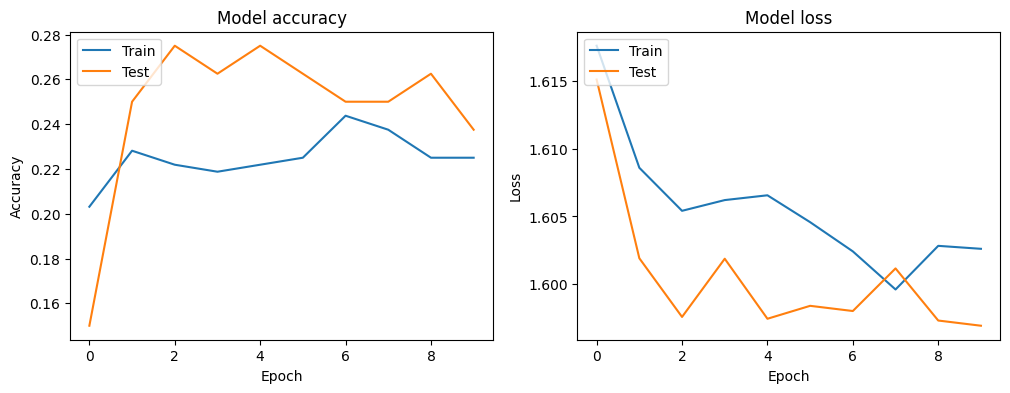

In [37]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
